In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
first = session.query(Measurement).first()
first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bd12d64128>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

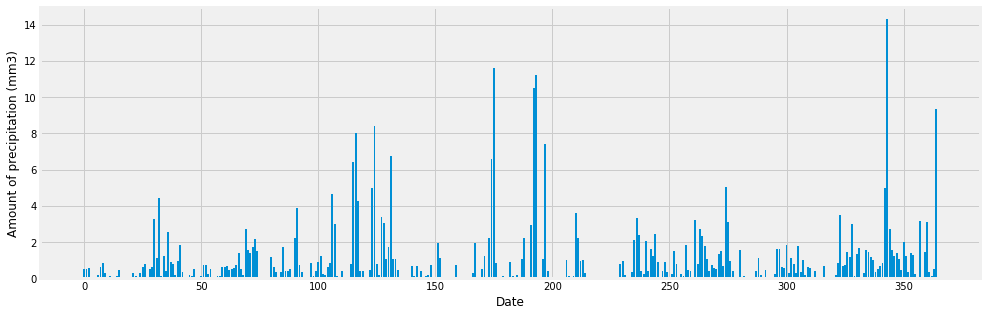

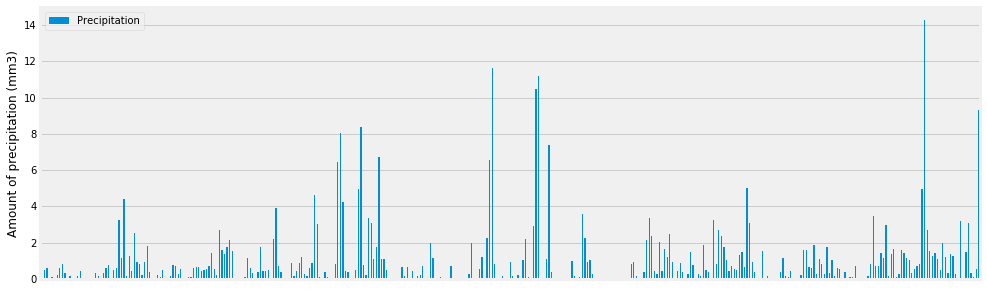

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = engine.execute("SELECT date, SUM(prcp) FROM Measurement GROUP BY date ORDER BY date DESC LIMIT 365").fetchall()

dates = []
rain = []

for i in range(len(data)):
    dates.append(data[i][0])
    rain.append(data[i][1])
    
x_axis = list(np.arange(365))
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(x_axis, rain)
ax.set_xlabel('Date')
ax.set_ylabel('Amount of precipitation (mm3)')

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({'Date': dates, 'Precipitation': rain})
df.set_index('Date');

# Sort the dataframe by date
# ALREADY DONE

# Use Pandas Plotting with Matplotlib to plot the data
fig, axes = plt.subplots(figsize=(15,5))
df.plot(ax=axes, kind='bar')
axes.set_xlabel('Date')
axes.set_ylabel('Amount of precipitation (mm3)')
axes.get_xaxis().set_visible(False);

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station)
print(len(list(stations)))

# Another option, using engine.execute
engine.execute('SELECT COUNT(station) FROM Station').fetchall()

9


[(9,)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('SELECT station, COUNT(date) AS dt_ct FROM Measurement GROUP BY station ORDER BY dt_ct DESC').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)] 
session.query(*sel).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

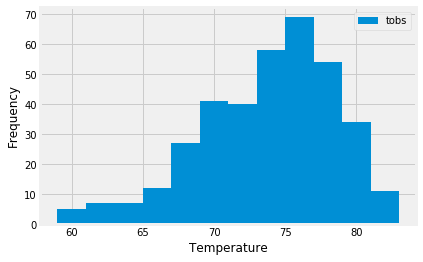

In [17]:
# Choose the station with the highest number of temperature observations.
high_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(Measurement.station==high_station).\
        group_by(Measurement.date).order_by(Measurement.date.desc()).limit(365).all()

temps_list = list(np.ravel(temps))
plt.hist(temps_list, label='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps_trip = calc_temps('2017-05-10','2017-05-25')
print(temps_trip)

[(68.0, 74.92222222222222, 87.0)]


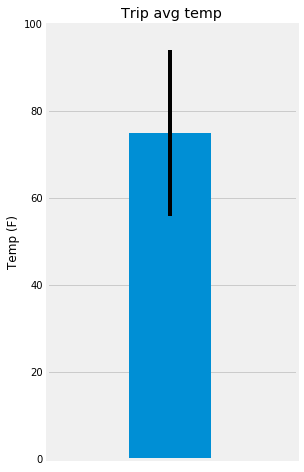

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(4,8))
x = [-1,0,1]
avg_temp = temps_trip[0][1]
error= temps_trip[0][2] - temps_trip[0][0]
ax.bar(x, height=avg_temp, width=0.1, align='edge', yerr=error)
ax.set_xlim(0.9)
ax.set_ylim(0,100)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip avg temp')
ax.get_xaxis().set_visible(False);

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rain = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date>='2017-05-10').\
              filter(Measurement.date<='2017-05-25').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(f'list of stations for my trip with total rainfall: {trip_rain}')
print('------------------------------------')

stations_list = []
for record in trip_rain:
    stations_list.append(record[0])

    
stations_det = []    
for station in stations_list:
    print(session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                        filter(Station.station==station).all())



list of stations for my trip with total rainfall: [('USC00516128', 6.94), ('USC00519281', 1.61), ('USC00519523', 1.74), ('USC00513117', 1.4), ('USC00514830', 0.51), ('USC00519397', 0.44000000000000006)]
------------------------------------
[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]
[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)]
[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]
[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)]
[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]
[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]


## Flask server

In [22]:
from flask import Flask

In [31]:
app = Flask(__name__)

@app.route('/')
def home():
    return(
        f'List of available routes:'
        f'/api/v1.0/precipitation'
        f'/api/v1.0/stations'
        f'/api/v1.0/tobs'
    )

@app.route('/api/v1.0/precipitation/<date>')
def prcp(date):
    result = list(np.ravel(session.query(Measurement.date, func.sum(Measurement.prcp)).filter(Measurement.date==date).all()))
    dict_result={result[0]:result[1]}
    
    return jsonify(dict_result)
    
    
#@app.route('/api/v1.0/stations')

#@app.route('/api/v1.0/tobs')

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Users\luron\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [54]:
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [55]:
date = list(date)
date = dt.datetime.strptime(date[0], '%Y-%m-%d')
year_date = date - dt.timedelta(days=365)
year_date = year_date.strftime('%Y-%m-%d')
year_date

'2016-08-23'

In [56]:
#date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date==year_date).\
order_by(Measurement.date.desc()).all()

[('2016-08-23', 'USC00519397', 81.0),
 ('2016-08-23', 'USC00513117', 76.0),
 ('2016-08-23', 'USC00514830', 80.0),
 ('2016-08-23', 'USC00517948', 80.0),
 ('2016-08-23', 'USC00519523', 80.0),
 ('2016-08-23', 'USC00519281', 77.0),
 ('2016-08-23', 'USC00516128', 74.0)]